## **Importing Libraries**

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

# **Stage 1**

## **Data Setup and Preview**

In [3]:
data_path = Path.home()/'notebooks/programming/data/watch_bot'
csv_path_1 = Path.home()/'notebooks/programming/projects/watch_bot/data_prep/file_attribs_watch_bot.csv'
csv_path_2 = Path.home()/'notebooks/programming/projects/watch_bot/data_prep/chrono24_dial_visibility_most_uncertain.csv'


In [4]:
df1 = pd.read_csv(csv_path_1)
df1.head()

,image_size_x,image_size_y,name,dial_visibility,like,image_quality
0,960,960,nomos_1/nomos/_without_model/nomos_@_the_loupe...,1.0,1.0,1.0
1,960,960,nomos_1/nomos/_without_model/nomos_@_the_loupe...,1.0,0.0,1.0
2,960,960,nomos_1/nomos/_without_model/nomos_@_the_loupe...,0.0,0.0,0.0
3,720,960,nomos_1/nomos/_without_model/nomos_beta_11156_...,1.0,0.0,1.0
4,720,960,nomos_1/nomos/_without_model/nomos_beta_11156_...,1.0,0.0,1.0


In [5]:
df1.shape

(11973, 6)

In [6]:
df2 = pd.read_csv(csv_path_2)
df2.head()

,image_size_x,image_size_y,name,dial_visibility,dial_visibility_p_0,dial_visibility_p_1,like,like_p_0,like_p_1,image_quality
0,640,480,chrono24_dial_visibility_most_uncertain/a._lan...,1.0,0.473409,0.526591,-1.0,-1,-1,-1.0
1,1200,718,chrono24_dial_visibility_most_uncertain/a._lan...,0.0,0.480346,0.519654,-1.0,-1,-1,-1.0
2,640,480,chrono24_dial_visibility_most_uncertain/a._lan...,0.0,0.471942,0.528058,-1.0,-1,-1,-1.0
3,640,480,chrono24_dial_visibility_most_uncertain/a._lan...,0.0,0.477966,0.522034,-1.0,-1,-1,-1.0
4,640,480,chrono24_dial_visibility_most_uncertain/a._lan...,0.0,0.471942,0.528058,-1.0,-1,-1,-1.0


In [7]:
df2.shape

(17142, 10)

In [8]:
df = pd.concat([df1, df2], ignore_index=True)
df = df.dropna(axis=1, how='any')
df

,image_size_x,image_size_y,name,dial_visibility,like,image_quality
0,960,960,nomos_1/nomos/_without_model/nomos_@_the_loupe...,1.0,1.0,1.0
1,960,960,nomos_1/nomos/_without_model/nomos_@_the_loupe...,1.0,0.0,1.0
2,960,960,nomos_1/nomos/_without_model/nomos_@_the_loupe...,0.0,0.0,0.0
3,720,960,nomos_1/nomos/_without_model/nomos_beta_11156_...,1.0,0.0,1.0
4,720,960,nomos_1/nomos/_without_model/nomos_beta_11156_...,1.0,0.0,1.0
...,...,...,...,...,...,...
29110,960,960,chrono24_dial_visibility_most_uncertain/zenith...,1.0,-1.0,-1.0
29111,960,960,chrono24_dial_visibility_most_uncertain/zenith...,1.0,-1.0,-1.0
29112,767,960,chrono24_dial_visibility_most_uncertain/zenith...,0.0,-1.0,-1.0
29113,720,960,chrono24_dial_visibility_most_uncertain/zenith...,0.0,-1.0,-1.0


In [9]:
df = df[['name', 'dial_visibility']]
df = df.astype({'dial_visibility':'int'})
df.dtypes

name               object
dial_visibility     int64
dtype: object

In [31]:
np.random.seed(13)
bs = 64
image_size = 128
xform = get_transforms(flip_vert=True, max_lighting=0.4, max_warp=0.1)

In [32]:
src = (ImageList.from_df(df, data_path)
        .split_by_rand_pct()
        .label_from_df())

In [33]:
data = (src.transform(tfms=xform, size=image_size)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [34]:
data

ImageDataBunch;

Train: LabelList (23292 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
1,1,0,1,1
Path: /home/neronicolo/notebooks/programming/data/watch_bot;

Valid: LabelList (5823 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
0,1,0,1,0
Path: /home/neronicolo/notebooks/programming/data/watch_bot;

Test: None

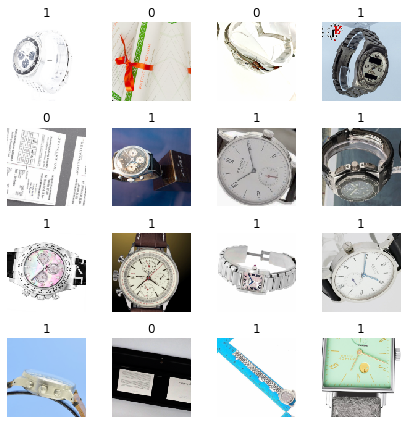

In [35]:
data.show_batch(rows=4, figsize=(6,6))

## **Training**

In [36]:
learn = create_cnn(data, models.resnet50, metrics=[accuracy])
learn = learn.to_fp16()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


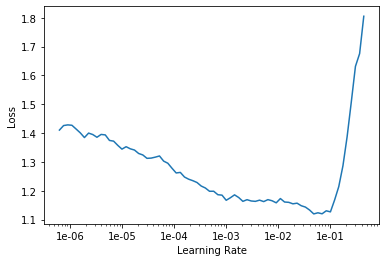

In [37]:
learn.lr_find()
learn.recorder.plot()

In [42]:
learn.fit_one_cycle(5, slice(1e-03))

epoch,train_loss,valid_loss,accuracy,time
0,0.184286,0.166289,0.931994,02:43
1,0.166782,0.163787,0.936631,02:42
2,0.158246,0.161532,0.936459,02:43
3,0.154331,0.157550,0.938348,02:43
4,0.168281,0.157637,0.939378,02:43


In [43]:
learn.save('stage_1')

In [45]:
''' Testing different learning rates
0	0.685181	0.399466	0.830156	02:43
1	0.495870	0.313964	0.862270	02:43
2	0.413907	0.289681	0.874463	02:43
3	0.365927	0.267587	0.882535	02:43
4	0.352246	0.261663	0.884596	02:43

learn.fit_one_cycle(5, slice(2e-05))
0	0.359081	0.261143	0.884596	02:44
1	0.348506	0.263082	0.881333	02:46
2	0.342516	0.258854	0.885798	02:43
3	0.329541	0.255236	0.886656	02:44
4	0.332251	0.257289	0.886141	02:43

learn.fit_one_cycle(5, slice(5e-03))
0	0.374916	0.333596	0.853168	02:50
1	0.314449	0.262811	0.887343	02:43
2	0.256623	0.218367	0.908295	02:43
3	0.231366	0.187211	0.923922	02:43
4	0.201210	0.183923	0.927185	02:44

learn.fit_one_cycle(5, slice(3e-03))
0	0.213692	0.191432	0.921003	02:44
1	0.232929	0.183315	0.927357	02:43
2	0.198101	0.173464	0.928216	02:44
3	0.187129	0.169419	0.933196	02:43
4	0.186906	0.168231	0.932509	02:43

learn.fit_one_cycle(5, slice(1e-03))
0	0.184286	0.166289	0.931994	02:43
1	0.166782	0.163787	0.936631	02:42
2	0.158246	0.161532	0.936459	02:43
3	0.154331	0.157550	0.938348	02:43
4	0.168281	0.157637	0.939378	02:43

''';

## **Interpreting**

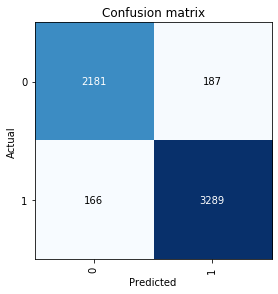

In [47]:
learn.load('stage_1')
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()